# Decoding Popularity on Hacker News: A Machine Learning Approach to Predicting Post Engagement

This project presents an analysis of post popularity on Hacker News using data from a 12-month period ending on April 2023. Our dataset encompasses over 300,000 posts, and our objective is to determine the factors that contribute to a post being classified as 'Popular', defined as receiving more than 8 reactions, which are a sum of comments and points.

To approach this binary classification problem, we initially considered a range of machine learning models. After a comprehensive evaluation process, which included assessing models such as Support Vector Machines and Gradient Boosting Trees, we selected Logistic Regression for its performance and interpretability. The model tuning was achieved through grid search techniques, focusing on optimizing the hyperparameters and the classification threshold to improve the f1 score for the 'Popular' class.

The subsequent sections will detail the methodologies applied in our exploratory data analysis, feature engineering, and model evaluation. We will also discuss the insights gained from the model coefficients, particularly in relation to the significance of words in post titles and the influence of external domains linked within these posts.

---
Source of dataset:
https://www.kaggle.com/datasets/santiagobasulto/all-hacker-news-posts-stories-askshow-hn-polls/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
hn = pd.read_csv('hn.csv')
hn

,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments
0,1,Y Combinator,story,pg,2006-10-09 18:21:51,http://ycombinator.com,61,18.0
1,2,A Student's Guide to Startups,story,phyllis,2006-10-09 18:30:28,http://www.paulgraham.com/mit.html,16,1.0
2,3,Woz Interview: the early days of Apple,story,phyllis,2006-10-09 18:40:33,http://www.foundersatwork.com/stevewozniak.html,7,1.0
3,4,NYC Developer Dilemma,story,onebeerdave,2006-10-09 18:47:42,http://avc.blogs.com/a_vc/2006/10/the_nyc_develop.html,5,1.0
4,5,"Google, YouTube acquisition announcement could come tonight",story,perler,2006-10-09 18:51:04,http://www.techcrunch.com/2006/10/09/google-youtube-sign-more-separate-deals/,7,1.0
...,...,...,...,...,...,...,...,...
3885794,35480629,Neovim 0.9 Released,story,eugene_pirogov,2023-04-07 11:50:56,https://github.com/neovim/neovim/commit/040f1459849ab05b04f6bb1e77b3def16b4c2f2b,2,0.0
3885795,35480632,Analogy between GPTs of today and CPUs from the early days of computing,story,cal85,2023-04-07 11:51:39,https://twitter.com/karpathy/status/1644183721405464576,1,0.0
3885796,35480641,"Show HN: Shoogle – fast, FOSS and tracking-free Yellow Pages powered by OSM data",show_hn,midzer,2023-04-07 11:53:17,https://us.shoogle.net/,1,1.0
3885797,35480652,UFOs had sexual encounters with witnesses and left woman pregnant: Pentagon docs,story,Gys,2023-04-07 11:54:59,https://www.news.com.au/technology/science/space/ufos-had-sexual-encounters-with-witnesses-and-left-one-woman-pregnant-bombshell-pentagon-docs-claim/news-story/ef4f818e09d2a753deec97d02cb97599,1,0.0


In [4]:
hn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885799 entries, 0 to 3885798
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Object ID           int64  
 1   Title               object 
 2   Post Type           object 
 3   Author              object 
 4   Created At          object 
 5   URL                 object 
 6   Points              int64  
 7   Number of Comments  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 237.2+ MB


## Data Cleaning

We will use the data for the last available 12 months (04/07/2022 - 04/07/2023). First we will convert date to datetime format.

In [5]:
hn['created_at'] = pd.to_datetime(hn['Created At'])

In [6]:
hn2 = hn[hn['created_at'] > pd.to_datetime('2022-04-07')].copy()
hn2

,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments,created_at
3583114,30939000,Hi-Mom – Say hi to your mom FAST,story,maydemir,2022-04-07 00:00:25,https://github.com/tsivinsky/hi-mom,2,0.0,2022-04-07 00:00:25
3583115,30939037,Bear hibernation: More than a winter’s nap,story,gmays,2022-04-07 00:05:02,https://knowablemagazine.org/article/living-world/2022/bear-hibernation-more-winters-nap,3,0.0,2022-04-07 00:05:02
3583116,30939040,"Show HN: The Causes of Latency in Computing Systems, and Why It Frustrates Us",show_hn,narner,2022-04-07 00:05:40,https://nickarner.com/notes/the-causes-of-latency-in-computing-systems-and-why-exactly-it-frustrates-us-april-6-2022/,4,0.0,2022-04-07 00:05:40
3583117,30939052,How much do you generate in terms of donations?,story,victor_e,2022-04-07 00:06:41,NaN,2,2.0,2022-04-07 00:06:41
3583118,30939055,Meet with Wallet,story,ycombdoramon,2022-04-07 00:07:18,https://meetwithwallet.xyz,2,0.0,2022-04-07 00:07:18
...,...,...,...,...,...,...,...,...,...
3885794,35480629,Neovim 0.9 Released,story,eugene_pirogov,2023-04-07 11:50:56,https://github.com/neovim/neovim/commit/040f1459849ab05b04f6bb1e77b3def16b4c2f2b,2,0.0,2023-04-07 11:50:56
3885795,35480632,Analogy between GPTs of today and CPUs from the early days of computing,story,cal85,2023-04-07 11:51:39,https://twitter.com/karpathy/status/1644183721405464576,1,0.0,2023-04-07 11:51:39
3885796,35480641,"Show HN: Shoogle – fast, FOSS and tracking-free Yellow Pages powered by OSM data",show_hn,midzer,2023-04-07 11:53:17,https://us.shoogle.net/,1,1.0,2023-04-07 11:53:17
3885797,35480652,UFOs had sexual encounters with witnesses and left woman pregnant: Pentagon docs,story,Gys,2023-04-07 11:54:59,https://www.news.com.au/technology/science/space/ufos-had-sexual-encounters-with-witnesses-and-left-one-woman-pregnant-bombshell-pentagon-docs-claim/news-story/ef4f818e09d2a753deec97d02cb97599,1,0.0,2023-04-07 11:54:59


### Introducing hour as the new feature

In [7]:
import matplotlib.style as style

style.use('dark_background')

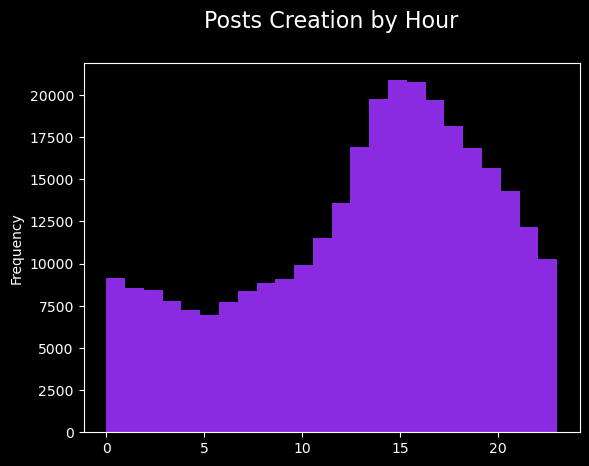

In [8]:
hn2['hour_created'] = hn2['created_at'].dt.hour

hn2['hour_created'].plot.hist(bins=24, color='blueviolet')
plt.title('Posts Creation by Hour'+'\n', size=16)
plt.show()

Most posts are created from around 12-00 to 18-00.

### Transforming URLs

First we will extract domains from url column.

In [9]:
from urllib.parse import urlparse

In [10]:
hn2['URL'] = hn2['URL'].fillna('no_url')

In [11]:
hn2['url_domain'] = hn2['URL'].apply(lambda x: urlparse(x).netloc)
hn2

,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments,created_at,hour_created,url_domain
3583114,30939000,Hi-Mom – Say hi to your mom FAST,story,maydemir,2022-04-07 00:00:25,https://github.com/tsivinsky/hi-mom,2,0.0,2022-04-07 00:00:25,0,github.com
3583115,30939037,Bear hibernation: More than a winter’s nap,story,gmays,2022-04-07 00:05:02,https://knowablemagazine.org/article/living-world/2022/bear-hibernation-more-winters-nap,3,0.0,2022-04-07 00:05:02,0,knowablemagazine.org
3583116,30939040,"Show HN: The Causes of Latency in Computing Systems, and Why It Frustrates Us",show_hn,narner,2022-04-07 00:05:40,https://nickarner.com/notes/the-causes-of-latency-in-computing-systems-and-why-exactly-it-frustrates-us-april-6-2022/,4,0.0,2022-04-07 00:05:40,0,nickarner.com
3583117,30939052,How much do you generate in terms of donations?,story,victor_e,2022-04-07 00:06:41,no_url,2,2.0,2022-04-07 00:06:41,0,
3583118,30939055,Meet with Wallet,story,ycombdoramon,2022-04-07 00:07:18,https://meetwithwallet.xyz,2,0.0,2022-04-07 00:07:18,0,meetwithwallet.xyz
...,...,...,...,...,...,...,...,...,...,...,...
3885794,35480629,Neovim 0.9 Released,story,eugene_pirogov,2023-04-07 11:50:56,https://github.com/neovim/neovim/commit/040f1459849ab05b04f6bb1e77b3def16b4c2f2b,2,0.0,2023-04-07 11:50:56,11,github.com
3885795,35480632,Analogy between GPTs of today and CPUs from the early days of computing,story,cal85,2023-04-07 11:51:39,https://twitter.com/karpathy/status/1644183721405464576,1,0.0,2023-04-07 11:51:39,11,twitter.com
3885796,35480641,"Show HN: Shoogle – fast, FOSS and tracking-free Yellow Pages powered by OSM data",show_hn,midzer,2023-04-07 11:53:17,https://us.shoogle.net/,1,1.0,2023-04-07 11:53:17,11,us.shoogle.net
3885797,35480652,UFOs had sexual encounters with witnesses and left woman pregnant: Pentagon docs,story,Gys,2023-04-07 11:54:59,https://www.news.com.au/technology/science/space/ufos-had-sexual-encounters-with-witnesses-and-left-one-woman-pregnant-bombshell-pentagon-docs-claim/news-story/ef4f818e09d2a753deec97d02cb97599,1,0.0,2023-04-07 11:54:59,11,www.news.com.au


In [12]:
hn2['url_domain'].value_counts().head(50)

                            22959
github.com                  13233
www.youtube.com             10788
twitter.com                  7336
en.wikipedia.org             5689
www.nytimes.com              4737
www.theguardian.com          3834
www.bloomberg.com            3600
www.wsj.com                  3307
arstechnica.com              3084
medium.com                   2944
www.theverge.com             2893
www.theregister.com          2522
www.reuters.com              2512
www.bbc.com                  2092
techcrunch.com               2029
www.nature.com               1691
www.cnbc.com                 1690
arxiv.org                    1637
www.washingtonpost.com       1586
www.ft.com                   1577
www.cnn.com                  1409
old.reddit.com               1370
www.wired.com                1330
phys.org                     1316
www.theatlantic.com          1285
www.bbc.co.uk                1116
www.businessinsider.com      1016
www.economist.com             969
www.npr.org   

We will select top-50 most used url domains, group the remaining, and categorize them all.

In [13]:
hn2.loc[hn2['url_domain'] == '', 'url_domain'] = hn2['URL']
hn2['url_domain'].value_counts()

no_url                  22959
github.com              13233
www.youtube.com         10788
twitter.com              7336
en.wikipedia.org         5689
                        ...  
www.workationlist.co        1
algorithms.design           1
blog.asana.com              1
blog.akerl.org              1
www.jacmusic.com            1
Name: url_domain, Length: 55229, dtype: int64

In [14]:
top_domains = hn2['url_domain'].value_counts().nlargest(50).index

hn2['domain_categorized'] = hn2['url_domain'].apply(lambda x: x if x in top_domains else 'other')

hn2['domain_categorized'].value_counts()

other                       178116
no_url                       22959
github.com                   13233
www.youtube.com              10788
twitter.com                   7336
en.wikipedia.org              5689
www.nytimes.com               4737
www.theguardian.com           3834
www.bloomberg.com             3600
www.wsj.com                   3307
arstechnica.com               3084
medium.com                    2944
www.theverge.com              2893
www.theregister.com           2522
www.reuters.com               2512
www.bbc.com                   2092
techcrunch.com                2029
www.nature.com                1691
www.cnbc.com                  1690
arxiv.org                     1637
www.washingtonpost.com        1586
www.ft.com                    1577
www.cnn.com                   1409
old.reddit.com                1370
www.wired.com                 1330
phys.org                      1316
www.theatlantic.com           1285
www.bbc.co.uk                 1116
www.businessinsider.

In [15]:
hn2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302685 entries, 3583114 to 3885798
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Object ID           302685 non-null  int64         
 1   Title               302681 non-null  object        
 2   Post Type           302685 non-null  object        
 3   Author              302685 non-null  object        
 4   Created At          302685 non-null  object        
 5   URL                 302685 non-null  object        
 6   Points              302685 non-null  int64         
 7   Number of Comments  302685 non-null  float64       
 8   created_at          302685 non-null  datetime64[ns]
 9   hour_created        302685 non-null  int64         
 10  url_domain          302685 non-null  object        
 11  domain_categorized  302685 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 38.1+ MB


### Transforming Author column

In [16]:
hn2['Author'].value_counts()

rntn              4003
Tomte             3978
mfiguiere         3390
mooreds           3157
tosh              2665
                  ... 
cain                 1
dillings             1
ghostpirate          1
krtab                1
eugene_pirogov       1
Name: Author, Length: 49364, dtype: int64

There are over 49k unique authors. We will categorize this feature as well, depending on how many posts each author made during the period:
- Inactive (authors with less than 1 post/month)
- Low active (more than 1 post/month, but less than 1 post/week)
- Medium active (more than 1 post/week, but less than 1 post per day)
- High active (more than 1 post per day)

In [17]:
# Calculating posting frequency
total_days = (hn2['created_at'].max() - hn2['created_at'].min()).days
post_counts = hn2.groupby('Author').size()
posts_per_day = post_counts / total_days

# Defining activity level categories
bins = [0, 1/30, 1/7, 1, float('inf')]
labels = ['Inactive', 'Low', 'Medium', 'High']
author_activity_levels = pd.cut(posts_per_day, bins, labels=labels)

# Merging with hn dataset
activity_level_df = pd.DataFrame({'Author': post_counts.index, 'author_activity': author_activity_levels}).reset_index(drop=True)
activity_level_df

,Author,author_activity
0,000000,Inactive
1,00117,Inactive
2,0066cc,Inactive
3,00702,Inactive
4,007lva,Inactive
...,...,...
49359,zzz_sleeping,Inactive
49360,zzzbra,Inactive
49361,zzzeek,Low
49362,zzzhangjinpeng,Inactive


In [18]:
hn3 = hn2.merge(activity_level_df, on='Author', how='left')
hn3

,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments,created_at,hour_created,url_domain,domain_categorized,author_activity
0,30939000,Hi-Mom – Say hi to your mom FAST,story,maydemir,2022-04-07 00:00:25,https://github.com/tsivinsky/hi-mom,2,0.0,2022-04-07 00:00:25,0,github.com,github.com,Medium
1,30939037,Bear hibernation: More than a winter’s nap,story,gmays,2022-04-07 00:05:02,https://knowablemagazine.org/article/living-world/2022/bear-hibernation-more-winters-nap,3,0.0,2022-04-07 00:05:02,0,knowablemagazine.org,other,High
2,30939040,"Show HN: The Causes of Latency in Computing Systems, and Why It Frustrates Us",show_hn,narner,2022-04-07 00:05:40,https://nickarner.com/notes/the-causes-of-latency-in-computing-systems-and-why-exactly-it-frustrates-us-april-6-2022/,4,0.0,2022-04-07 00:05:40,0,nickarner.com,other,Inactive
3,30939052,How much do you generate in terms of donations?,story,victor_e,2022-04-07 00:06:41,no_url,2,2.0,2022-04-07 00:06:41,0,no_url,no_url,Inactive
4,30939055,Meet with Wallet,story,ycombdoramon,2022-04-07 00:07:18,https://meetwithwallet.xyz,2,0.0,2022-04-07 00:07:18,0,meetwithwallet.xyz,other,Inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302680,35480629,Neovim 0.9 Released,story,eugene_pirogov,2023-04-07 11:50:56,https://github.com/neovim/neovim/commit/040f1459849ab05b04f6bb1e77b3def16b4c2f2b,2,0.0,2023-04-07 11:50:56,11,github.com,github.com,Inactive
302681,35480632,Analogy between GPTs of today and CPUs from the early days of computing,story,cal85,2023-04-07 11:51:39,https://twitter.com/karpathy/status/1644183721405464576,1,0.0,2023-04-07 11:51:39,11,twitter.com,twitter.com,Low
302682,35480641,"Show HN: Shoogle – fast, FOSS and tracking-free Yellow Pages powered by OSM data",show_hn,midzer,2023-04-07 11:53:17,https://us.shoogle.net/,1,1.0,2023-04-07 11:53:17,11,us.shoogle.net,other,Low
302683,35480652,UFOs had sexual encounters with witnesses and left woman pregnant: Pentagon docs,story,Gys,2023-04-07 11:54:59,https://www.news.com.au/technology/science/space/ufos-had-sexual-encounters-with-witnesses-and-left-one-woman-pregnant-bombshell-pentagon-docs-claim/news-story/ef4f818e09d2a753deec97d02cb97599,1,0.0,2023-04-07 11:54:59,11,www.news.com.au,other,Inactive


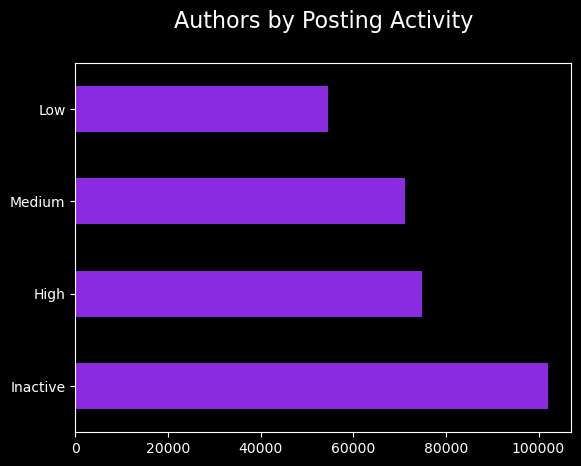

In [19]:
hn3['author_activity'].value_counts().plot.barh(color='blueviolet')
plt.title('Authors by Posting Activity'+'\n', size=16)
plt.show()

### Transforming Title

First we will drop the columns we will not need.

In [21]:
hn4 = hn3.drop(['Object ID', 'Author', 'Created At', 'URL', 'created_at', 'url_domain'], axis=1)
hn4

,Title,Post Type,Points,Number of Comments,hour_created,domain_categorized,author_activity
0,Hi-Mom – Say hi to your mom FAST,story,2,0.0,0,github.com,Medium
1,Bear hibernation: More than a winter’s nap,story,3,0.0,0,other,High
2,"Show HN: The Causes of Latency in Computing Systems, and Why It Frustrates Us",show_hn,4,0.0,0,other,Inactive
3,How much do you generate in terms of donations?,story,2,2.0,0,no_url,Inactive
4,Meet with Wallet,story,2,0.0,0,other,Inactive
...,...,...,...,...,...,...,...
302680,Neovim 0.9 Released,story,2,0.0,11,github.com,Inactive
302681,Analogy between GPTs of today and CPUs from the early days of computing,story,1,0.0,11,twitter.com,Low
302682,"Show HN: Shoogle – fast, FOSS and tracking-free Yellow Pages powered by OSM data",show_hn,1,1.0,11,other,Low
302683,UFOs had sexual encounters with witnesses and left woman pregnant: Pentagon docs,story,1,0.0,11,other,Inactive


In [22]:
# Checking for missing values
hn4[hn4['Title'].isna()]

,Title,Post Type,Points,Number of Comments,hour_created,domain_categorized,author_activity
139105,NaN,story,3,2.0,16,no_url,Inactive
169609,NaN,story,1,0.0,20,no_url,Medium
227106,NaN,story,2,0.0,0,other,Medium
235782,NaN,story,1,1.0,6,no_url,Inactive


In [23]:
# Dropping rows with missing values
hn5 = hn4[hn4['Title'].notna()].copy()

Now we will remove unnecessary characters from the Title column.

In [24]:
import string
import re

In [25]:
def clean_title(text):
    # Removing all characters except English letters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Removing Ask HN and Show HN
    text = re.sub('Show HN ', '', text)
    text = re.sub('Ask HN ', '', text)

    # Removing extra spaces
    text = re.sub('\s+', ' ', text).strip()

    return text

In [26]:
hn5['Title'] = hn5['Title'].apply(clean_title).str.lower()

In [27]:
hn5['Title']

0                                                          hi mom say hi to your mom fast
1                                               bear hibernation more than a winter s nap
2                     the causes of latency in computing systems and why it frustrates us
3                                          how much do you generate in terms of donations
4                                                                        meet with wallet
                                               ...                                       
302680                                                                    neovim released
302681            analogy between gpts of today and cpus from the early days of computing
302682               shoogle fast foss and tracking free yellow pages powered by osm data
302683    ufos had sexual encounters with witnesses and left woman pregnant pentagon docs
302684                                           my never complete tube tester collection
Name: Titl

Next we will reduce words to their root form so that we can use them for Bag of Words model.

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [29]:
# Tokenizing title
hn5['title_tokenized'] = hn5['Title'].apply(word_tokenize)
hn5['title_tokenized']

0                                                              [hi, mom, say, hi, to, your, mom, fast]
1                                                   [bear, hibernation, more, than, a, winter, s, nap]
2                     [the, causes, of, latency, in, computing, systems, and, why, it, frustrates, us]
3                                             [how, much, do, you, generate, in, terms, of, donations]
4                                                                                 [meet, with, wallet]
                                                      ...                                             
302680                                                                              [neovim, released]
302681           [analogy, between, gpts, of, today, and, cpus, from, the, early, days, of, computing]
302682               [shoogle, fast, foss, and, tracking, free, yellow, pages, powered, by, osm, data]
302683    [ufos, had, sexual, encounters, with, witnesses, and, left, wom

In [30]:
# Removing stopwords
hn5['title_tokenized'] = hn5['title_tokenized'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])

In [31]:
hn5['title_tokenized']

0                                                        [hi, mom, say, hi, mom, fast]
1                                                     [bear, hibernation, winter, nap]
2                                [causes, latency, computing, systems, frustrates, us]
3                                                   [much, generate, terms, donations]
4                                                                       [meet, wallet]
                                              ...                                     
302680                                                              [neovim, released]
302681                            [analogy, gpts, today, cpus, early, days, computing]
302682        [shoogle, fast, foss, tracking, free, yellow, pages, powered, osm, data]
302683    [ufos, sexual, encounters, witnesses, left, woman, pregnant, pentagon, docs]
302684                                     [never, complete, tube, tester, collection]
Name: title_tokenized, Length: 302681, dtyp

In [32]:
# Stemming
stemmer = PorterStemmer()

hn5['title_tokenized'] = hn5['title_tokenized'].apply(lambda x: [stemmer.stem(word) for word in x])

In [33]:
hn5['title_tokenized']

0                                             [hi, mom, say, hi, mom, fast]
1                                               [bear, hibern, winter, nap]
2                              [caus, latenc, comput, system, frustrat, us]
3                                                [much, gener, term, donat]
4                                                            [meet, wallet]
                                        ...                                
302680                                                     [neovim, releas]
302681                        [analog, gpt, today, cpu, earli, day, comput]
302682    [shoogl, fast, foss, track, free, yellow, page, power, osm, data]
302683    [ufo, sexual, encount, wit, left, woman, pregnant, pentagon, doc]
302684                              [never, complet, tube, tester, collect]
Name: title_tokenized, Length: 302681, dtype: object

Now we can implement Bag of Words for Title. To reduce dimensionality, we will use top-500 most frequent words only.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
vectorizer = CountVectorizer(max_features=500)

# Joining the tokens into a single string for each title
title_joined = hn5['title_tokenized'].apply(lambda x: ' '.join(x))

# Using CountVectorizer
title_bow = vectorizer.fit_transform(title_joined)

In [36]:
title_bow_arr = title_bow.toarray()
title_names = vectorizer.get_feature_names_out()

title_bow_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
title_names

array(['access', 'account', 'action', 'activ', 'ad', 'add', 'age', 'ai',
       'air', 'algorithm', 'altern', 'amazon', 'america', 'american',
       'analysi', 'android', 'anim', 'announc', 'anyon', 'api', 'app',
       'appl', 'applic', 'architectur', 'art', 'ask', 'attack', 'autom',
       'avail', 'aw', 'back', 'bad', 'ban', 'bank', 'base', 'batteri',
       'becom', 'behind', 'best', 'better', 'big', 'bill', 'bitcoin',
       'black', 'block', 'blog', 'book', 'brain', 'break', 'bring',
       'browser', 'bug', 'build', 'built', 'busi', 'buy', 'california',
       'call', 'car', 'case', 'caus', 'ceo', 'challeng', 'chang', 'charg',
       'chat', 'chatgpt', 'china', 'chines', 'chip', 'chrome', 'citi',
       'claim', 'client', 'climat', 'close', 'cloud', 'co', 'code',
       'collect', 'com', 'come', 'command', 'commun', 'compani', 'compil',
       'complet', 'comput', 'connect', 'content', 'control', 'cost',
       'could', 'court', 'covid', 'crash', 'creat', 'crisi', 'crypto',
   

### Creating response variable

We will combine points and comments into new response, which will reflect the popularity of the post.

In [38]:
y = hn5['Points'] + hn5['Number of Comments']

In [39]:
y.describe()

count    302681.000000
mean         34.078677
std         126.110349
min           1.000000
25%           2.000000
50%           3.000000
75%           8.000000
max        6599.000000
dtype: float64

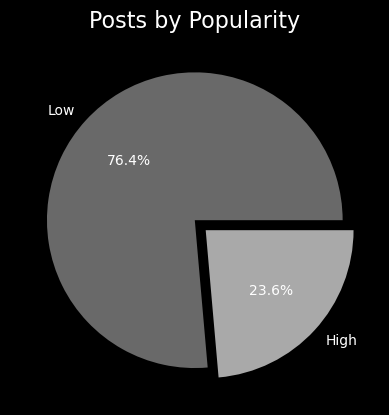

In [40]:
bins = [0, 8, np.inf]
labels = ['Low', 'High']

pd.cut(y, bins=bins, labels=labels).value_counts().plot.pie(normalize=True,
                                                            colors=['dimgray', 'darkgrey'],
                                                            labels=labels,
                                                            autopct='%1.1f%%',
                                                            explode = (0, 0.1))
plt.title('Posts by Popularity', size=16)
plt.show()

We will use 8 reactions (75th percentile) as a threshold that defines popular post, since it represents an adequate share of total posts.

In [41]:
y_cat = np.ones(y.shape[0])

y_cat[y < 8] = 0

y_cat

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
y_cat.sum()

76618.0

### One-hot encoding and combining all features

In [43]:
X = hn5[['Post Type', 'hour_created', 'domain_categorized', 'author_activity']].copy()

X.rename({'Post Type' : 'type', 'domain_categorized' : 'url'}, axis=1, inplace=True)

X

,type,hour_created,url,author_activity
0,story,0,github.com,Medium
1,story,0,other,High
2,show_hn,0,other,Inactive
3,story,0,no_url,Inactive
4,story,0,other,Inactive
...,...,...,...,...
302680,story,11,github.com,Inactive
302681,story,11,twitter.com,Low
302682,show_hn,11,other,Low
302683,story,11,other,Inactive


In [44]:
X = pd.get_dummies(X, drop_first=True)

feature_names = X.columns.to_list()

X = np.asarray(X)

feature_names

['hour_created',
 'type_poll',
 'type_show_hn',
 'type_story',
 'url_arstechnica.com',
 'url_arxiv.org',
 'url_en.wikipedia.org',
 'url_github.blog',
 'url_github.com',
 'url_gizmodo.com',
 'url_hackaday.com',
 'url_lite.cnn.com',
 'url_medium.com',
 'url_no_url',
 'url_old.reddit.com',
 'url_other',
 'url_phys.org',
 'url_spectrum.ieee.org',
 'url_techcrunch.com',
 'url_theconversation.com',
 'url_thenewstack.io',
 'url_twitter.com',
 'url_www.axios.com',
 'url_www.bbc.co.uk',
 'url_www.bbc.com',
 'url_www.bleepingcomputer.com',
 'url_www.bloomberg.com',
 'url_www.businessinsider.com',
 'url_www.cnbc.com',
 'url_www.cnn.com',
 'url_www.economist.com',
 'url_www.engadget.com',
 'url_www.forbes.com',
 'url_www.ft.com',
 'url_www.macrumors.com',
 'url_www.nature.com',
 'url_www.newyorker.com',
 'url_www.npr.org',
 'url_www.nytimes.com',
 'url_www.phoronix.com',
 'url_www.quantamagazine.org',
 'url_www.reuters.com',
 'url_www.science.org',
 'url_www.technologyreview.com',
 'url_www.theatl

In [45]:
feature_names2 = np.concatenate((feature_names, ('title_' + title_names)))
feature_names2

array(['hour_created', 'type_poll', 'type_show_hn', 'type_story',
       'url_arstechnica.com', 'url_arxiv.org', 'url_en.wikipedia.org',
       'url_github.blog', 'url_github.com', 'url_gizmodo.com',
       'url_hackaday.com', 'url_lite.cnn.com', 'url_medium.com',
       'url_no_url', 'url_old.reddit.com', 'url_other', 'url_phys.org',
       'url_spectrum.ieee.org', 'url_techcrunch.com',
       'url_theconversation.com', 'url_thenewstack.io', 'url_twitter.com',
       'url_www.axios.com', 'url_www.bbc.co.uk', 'url_www.bbc.com',
       'url_www.bleepingcomputer.com', 'url_www.bloomberg.com',
       'url_www.businessinsider.com', 'url_www.cnbc.com',
       'url_www.cnn.com', 'url_www.economist.com', 'url_www.engadget.com',
       'url_www.forbes.com', 'url_www.ft.com', 'url_www.macrumors.com',
       'url_www.nature.com', 'url_www.newyorker.com', 'url_www.npr.org',
       'url_www.nytimes.com', 'url_www.phoronix.com',
       'url_www.quantamagazine.org', 'url_www.reuters.com',
       'ur

In [46]:
X = np.concatenate((X, title_bow_arr), axis=1)

In [47]:
X.shape

(302681, 557)

## Logistic Regression

We will start with logistic regression, and grid-seach for optimal hyperparameters.

In [48]:
import sklearn.model_selection as skm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [49]:
# Scaling the non-binary feature
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)

X0_scaled = scaler.fit_transform(X[:,0].reshape(-1,1))
Xrest = X[:,1:]

X_scaled = np.concatenate((X0_scaled, Xrest), axis=1)

In [50]:
X_train, X_test, y_train, y_test = skm.train_test_split(X_scaled, y_cat, test_size=0.25, random_state=212)

In [51]:
kfold = skm.KFold(5, 
                  random_state=212,
                  shuffle=True)

We will use f1 score as a scoring parameter for grid search, since we are mostly interested in indentifying 'Popular' posts, that represent only under 25% of total observations.

In [52]:
logit = SGDClassifier(loss='log_loss',
                      max_iter=1000,
                      n_jobs=-1,
                      early_stopping=True,
                      class_weight='balanced')

logit_params = {'penalty':['l1', 'l2', 'elasticnet'],
                'alpha':[0.0001, 0.001, 0.01, 0.1]}

gs_logit = skm.GridSearchCV(logit, logit_params, cv=kfold, scoring='f1')
gs_logit.fit(X_train, y_train)

gs_logit.best_params_

{'alpha': 0.0001, 'penalty': 'l2'}

The best model implements weak l2 regularization, with no feature selection.

In [53]:
print('Log Regression'+'\n')
print(classification_report(y_test, gs_logit.best_estimator_.predict(X_test)))

Log Regression

              precision    recall  f1-score   support

         0.0       0.80      0.60      0.68     56382
         1.0       0.33      0.57      0.41     19289

    accuracy                           0.59     75671
   macro avg       0.56      0.58      0.55     75671
weighted avg       0.68      0.59      0.62     75671



Logistic regression shows moderate recall and precision for 'Popular' class.

We will try to improve results with different models.

## Linear SVC

Next we will try linear support vector classifier.

In [56]:
svc = SGDClassifier(loss='hinge',
                    max_iter=1000,
                    n_jobs=-1,
                    early_stopping=True,
                    class_weight='balanced')

svc_params = {'penalty':['l1', 'l2', 'elasticnet'],
                'alpha':[0.0001, 0.001, 0.01, 0.1]}

gs_svc = skm.GridSearchCV(svc, svc_params, cv=kfold, scoring='f1')
gs_svc.fit(X_train, y_train)

gs_svc.best_params_

{'alpha': 0.0001, 'penalty': 'l2'}

In [57]:
print('Linear SVC'+'\n')
print(classification_report(y_test, gs_svc.best_estimator_.predict(X_test)))

Linear SVC

              precision    recall  f1-score   support

         0.0       0.80      0.66      0.72     56382
         1.0       0.34      0.51      0.40     19289

    accuracy                           0.62     75671
   macro avg       0.57      0.58      0.56     75671
weighted avg       0.68      0.62      0.64     75671



Linear Support Vector Classifier shows slightly worse performance for Popular class.

## Support Vector Machine

Due to large size of the data set, we will approximate radial kernel transformation with Nystroem transformer, and then use Stochastic Gradient Descent Classfier.

In [59]:
from sklearn.kernel_approximation import Nystroem

In [60]:
feature_map_nystroem = Nystroem(gamma=0.1,
                                random_state=212,
                                n_components=500,
                                n_jobs=-1)

# Tranforming feature space
X_train_nystroem = feature_map_nystroem.fit_transform(X_train)
X_test_nystroem = feature_map_nystroem.transform(X_test)

In [61]:
svm_rbf = SGDClassifier(loss='hinge',
                    max_iter=1000,
                    n_jobs=-1,
                    early_stopping=True,
                    class_weight='balanced')

svm_params = {'penalty':['l1', 'l2', 'elasticnet'],
                'alpha':[0.0001, 0.001, 0.01, 0.1]}

gs_svm = skm.GridSearchCV(svm_rbf, svm_params, cv=kfold, scoring='f1')
gs_svm.fit(X_train_nystroem, y_train)

gs_svm.best_params_

{'alpha': 0.0001, 'penalty': 'l1'}

In [62]:
print('SVM'+'\n')
print(classification_report(y_test, gs_svm.best_estimator_.predict(X_test_nystroem)))

SVM

              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78     56382
         1.0       0.36      0.35      0.36     19289

    accuracy                           0.68     75671
   macro avg       0.57      0.57      0.57     75671
weighted avg       0.67      0.68      0.68     75671



SVM with radial kernel shows highest recall for 'Popular' class at the expense of recall, sorting more observations into 'Not popular' class.

## Gradient Boosting Classifier

We will use histogram gradient boosting which is much faster for large data sets.

In [64]:
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC

In [65]:
gbc = HGBC(random_state=212,
           max_iter=1000,
           class_weight='balanced',
           max_depth=3)

gbc_params = {'learning_rate' : [0.1, 1],
              'l2_regularization' : [0.1, 0]}

gs_gbc = skm.GridSearchCV(gbc, gbc_params, cv=kfold, scoring='f1')
gs_gbc.fit(X_train, y_train)

gs_gbc.best_params_

{'l2_regularization': 0.1, 'learning_rate': 0.1}

In [66]:
print('Gradient Boosting'+'\n')
print(classification_report(y_test, gs_gbc.best_estimator_.predict(X_test)))

Gradient Boosting

              precision    recall  f1-score   support

         0.0       0.80      0.68      0.73     56382
         1.0       0.34      0.49      0.40     19289

    accuracy                           0.63     75671
   macro avg       0.57      0.58      0.57     75671
weighted avg       0.68      0.63      0.65     75671



GBC shows comparable performance to Logistic Regression. We will use more simple Logistic Regression since it offers good interpretability, which is valuable for understanding the factors influencing post popularity.

## Threshold-tuning Logistic Regression

We can explore different threshold, e.g. 0.45, for classifying a post as 'Popular' to see if there's a better balance between precision and recall for our specific business needs

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

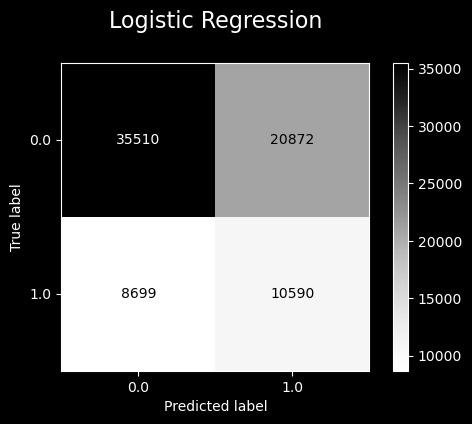

In [72]:
fig, ax = plt.subplots(figsize=(6, 4))
display = ConfusionMatrixDisplay.from_estimator(gs_logit.best_estimator_,
                                                X_test, y_test,
                                                ax=ax,
                                                cmap=plt.cm.Greys)

plt.title('Logistic Regression'+'\n', size=16)
plt.show()

Now we change the threshold and compare the confusion matrix.

In [73]:
logit_best = gs_logit.best_estimator_

In [118]:
logit_pred_prob_1 = logit_best.predict_proba(X_test)[:,1]

# Setting threshold at 0.45
y_pred_thres = (logit_pred_prob_1 >= 0.45).astype(int)

In [119]:
print('Log Reg, new threshold'+'\n')
print(classification_report(y_test, y_pred_thres))

Log Reg, new threshold

              precision    recall  f1-score   support

         0.0       0.83      0.39      0.53     56382
         1.0       0.30      0.77      0.43     19289

    accuracy                           0.49     75671
   macro avg       0.57      0.58      0.48     75671
weighted avg       0.70      0.49      0.51     75671



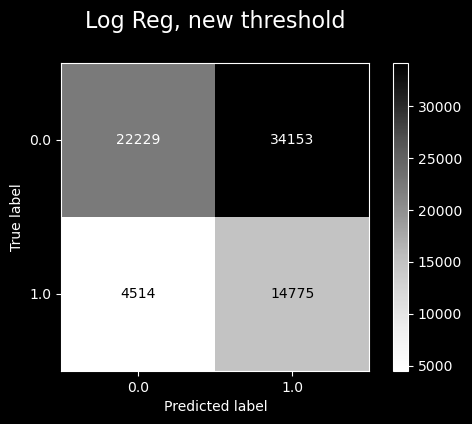

In [120]:
fig, ax = plt.subplots(figsize=(6, 4))
display = ConfusionMatrixDisplay.from_predictions(
                                                y_test, y_pred_thres,
                                                ax=ax,
                                                cmap=plt.cm.Greys)

plt.title('Log Reg, new threshold'+'\n', size=16)
plt.show()

We see that with adjusted threshold the model sorts more observations into 'Popular' class, increasing recall, at the cost of worse precision and overall accuracy. The choice of threshold would depend on the specific business context and objectives. Adjusting the classification threshold can help tailor the sensitivity and specificity of the model to align with particular goals at hand.

## Feature Analysis

Now we will examine the coefficients associated with each feature, and identify which specific words, hour of posting or phrases from the Bag of Words are most strongly associated with 'Popular' and 'Not Popular' classes.

In [68]:
# Fitting the model on the full data set
logit_best = gs_logit.best_estimator_
logit_best.fit(X_scaled, y_cat)

SGDClassifier(class_weight='balanced', early_stopping=True, loss='log_loss',
              n_jobs=-1)

In [69]:
# Extracting coefficients
logit_coefs = logit_best.coef_[0]

feature_importance = pd.DataFrame({'Feature': feature_names2, 'Logit_Coef': logit_coefs})

feature_importance

,Feature,Logit_Coef
0,hour_created,-0.040608
1,type_poll,-0.365427
2,type_show_hn,-0.138307
3,type_story,-0.535571
4,url_arstechnica.com,0.232532
...,...,...
552,title_write,0.018077
553,title_wrong,0.354670
554,title_year,0.197569
555,title_youtub,0.015105


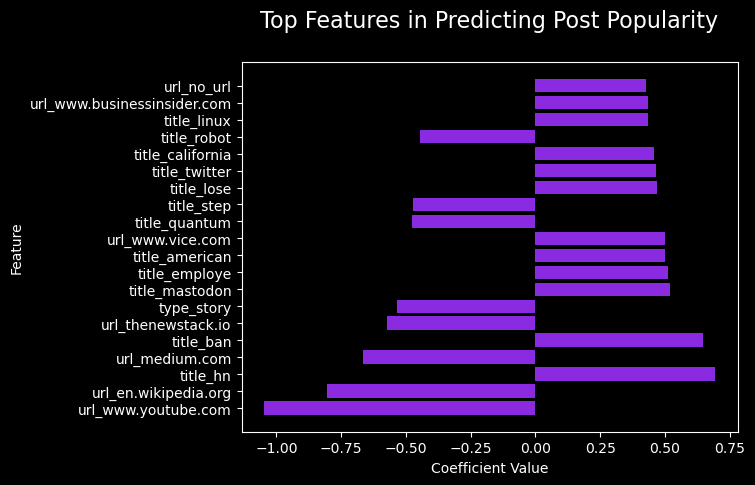

In [71]:
# Selecting top-20 most important features
top_features = feature_importance.sort_values(by='Logit_Coef', key=abs, ascending=False).head(20)

plt.barh(top_features['Feature'],
         top_features['Logit_Coef'],
         color='blueviolet')

plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top Features in Predicting Post Popularity'+'\n', size=16)

plt.show()

Some words in the title might indicate that a post will get over 8 reactions (hn, ban, mastodon, employee etc.), while links to certain sites (YouTube, Wikipedia, medium.com, thenewsstack.io) tend to attract less reaction. Posts labeled as story might be less popular as well. Despite certain trends in hour of posting, it appears to not have any significant effect on the number of reactions the post gets, nor does the activity level of the post's author.

# Conclusion

Through rigorous analysis of a substantial dataset from Hacker News, we sought to uncover the attributes that predispose a post to be deemed 'Popular'. Our investigation spanned numerous machine learning models, where we measured performance primarily by the f1 score due to the imbalanced nature of our response variable. Logistic Regression emerged as the model of choice, balancing simplicity with predictive power.

The model's findings shed light on various features that correlate with post popularity. Notably, certain keywords within titles and the source domains of posted content were identified as significant predictors. While words such as 'hn', 'ban', and 'mastodon' tended to predict popularity, posts linking to domains like YouTube and Wikipedia were less likely to be classified as 'Popular'. Additionally, the post type 'story' was found to be a less influential feature.

It is important to highlight that these results, while insightful, are predictive and not necessarily causative. Furthermore, the choice of threshold for classifying posts as 'Popular' is somewhat arbitrary and should be tailored to the specific needs and context of application.

As we conclude, our analysis provides a foundation for understanding engagement on Hacker News and suggests avenues for content strategists to potentially amplify the reach of their posts. Future work may involve incorporating additional contextual data, refining feature engineering, or exploring more complex models to build upon the groundwork laid by this project.